In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jaxquantum as jqt
import jaxquantum.circuits as jqtc
import jaxquantum.codes as jqtb
from jax import jit, grad
import jax.numpy as jnp
from math import prod
import matplotlib.pyplot as plt

from tqdm import tqdm

import jax
import optax
import functools

In [3]:
def MX_plus():

    g = jqt.basis(2,0)
    e = jqt.basis(2,1)
    plus = (g + e).unit()
    pp = plus @ plus.dag()
    kmap = jqt.QarrayArray.create([2*pp])

    return jqtc.Gate.create(
        2, 
        name="MXplus",
        gen_KM = lambda params: kmap,
        num_modes=1
    )

In [4]:
def run_circuit(params):
    gammas_x = 2*jnp.pi*params[0]
    gammas_y = 2*jnp.pi*params[1]
    betas = params[2]
    
    N = 30
    reg = jqtc.Register([2,N])
    cirq = jqtc.Circuit.create(reg, layers=[])

    for i in range(len(gammas_x)):
        cirq.append(jqtc.Rx(gammas_x[i]), 0)
        cirq.append(jqtc.Ry(gammas_y[i]), 0)
        cirq.append(jqtc.CD(N, betas[i]), [0, 1])
    
    # cirq.append(MX_plus(), 0, default_simulate_mode="kraus")

    initial_state = jqt.basis(2,0) ^ jqt.basis(N,0)
    res = jqtc.simulate(cirq, initial_state, mode="default")

    return res[-1][-1].unit()

Text(62.44444444444453, 0.5, 'Im[α]')

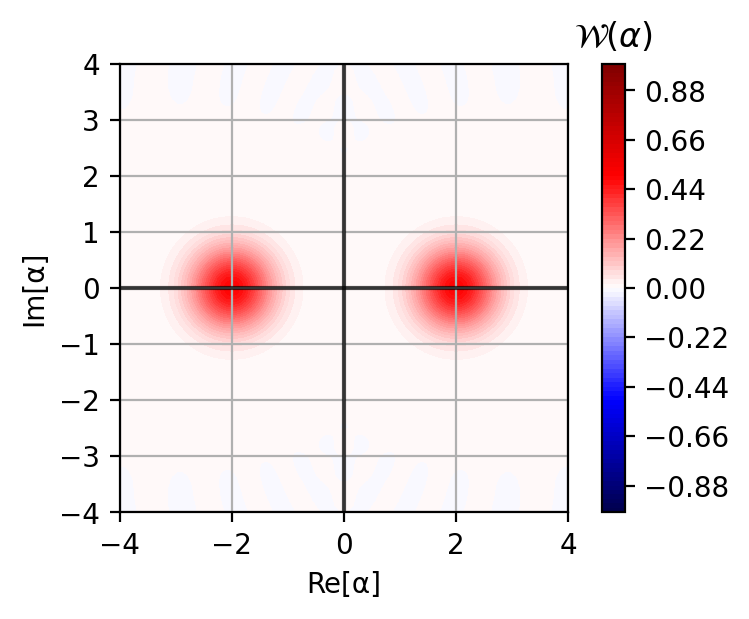

In [5]:
params = jnp.array([[0.0,0.0], [0.25,0.0], [4,0.0]])

final_state = run_circuit(
    params
)

state = final_state
pts = jnp.linspace(-4,4, 101)
ax, im = jqt.plot_wigner(jqt.ptrace(state,1), pts)
ax.set_xlabel("Re[α]")
ax.set_ylabel("Im[α]")

Text(0.5, 1.0, 'Squeezing level: 6.02 dB')

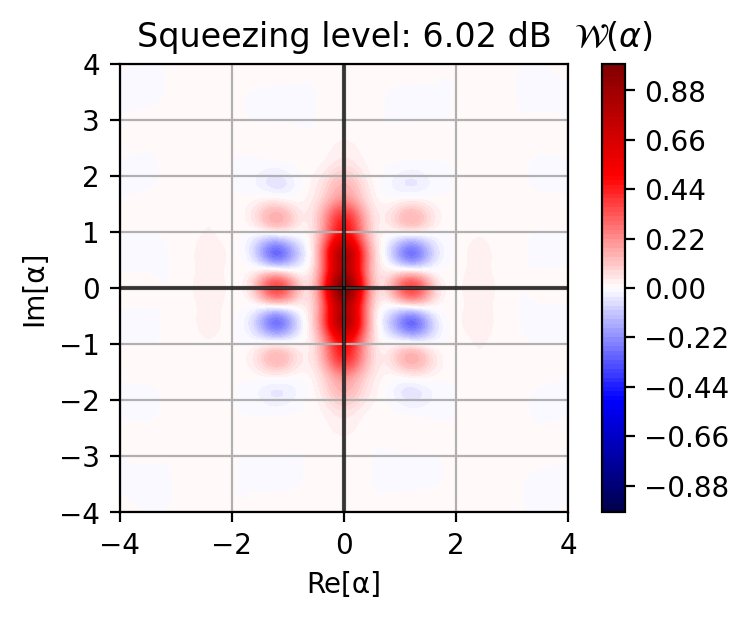

In [6]:
delta = 0.5
gkp_qubit = jqtb.GKPQubit({"delta": delta, "N": 30})
squeezing_level = 20*jnp.log10(jnp.exp(jnp.abs(jnp.log(delta))))

target_state = gkp_qubit.basis["+z"]
pts = jnp.linspace(-4,4, 101)
ax, im = jqt.plot_wigner(target_state, pts)
ax.set_xlabel("Re[α]")
ax.set_ylabel("Im[α]")
ax.set_title(f"Squeezing level: {squeezing_level:.2f} dB")

In [7]:
def fid_metric(params):
    N = 30
    prepared_state = jqt.ptrace(run_circuit(params),1)
    return jnp.real(jqt.overlap(target_state, prepared_state).data[0][0])

fid_metric_vmap = jax.vmap(fid_metric, in_axes=(0,))

def metric(params):
    fids = fid_metric_vmap(params)
    losses = jnp.log(1 - fids)
    avg_loss = jnp.average(losses)
    return avg_loss

metric(jnp.array([params,2*params]))

Array(-0.01756547, dtype=float64)

# Batch Gradient Descent

In [8]:
# Functions
metric_val_and_grad = jit(jax.value_and_grad(metric))
fid_metric_vmap_jit = jit(fid_metric_vmap)

# Parameters
key = jax.random.PRNGKey(0)  # Initialize a random key
B = 500 # Batch size
num_blocks = 6
lower_bounds = jnp.array([-1, -1, -20])  # Define the lower bounds for each axis
upper_bounds = jnp.array([1, 1, 20])    # Define the upper bounds for each axis
random_initial_params = jax.random.uniform(
    key, shape=(B, 3, num_blocks), minval=lower_bounds[:, None], maxval=upper_bounds[:, None]
)

# Warm-up
%timeit -n1 -r1 metric_val_and_grad(random_initial_params)[0].block_until_ready()
%timeit -n1 -r1 fid_metric_vmap_jit(random_initial_params).block_until_ready()

# Should be faster
%timeit -n1 -r1 metric_val_and_grad(random_initial_params)[0].block_until_ready()
%timeit -n1 -r1 fid_metric_vmap_jit(random_initial_params).block_until_ready()

19.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
5.91 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
10.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.56 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [9]:
start_learning_rate = 1e-3
optimizer = optax.adam(start_learning_rate)
params = random_initial_params
opt_state = optimizer.init(params)

# A simple update loop.
params_history = []
fids_history = []
metric_history = []

epochs = 200
for j in tqdm(range(epochs)):
  params_history.append(params)
  fids_history.append(fid_metric_vmap_jit(params))
  metric, grads = metric_val_and_grad(params)
  metric_history.append(metric)

  if j % 10 == 0:
    print(f"Epoch {j}: metric = {metric:.4f}, best fid = {jnp.max(fids_history[-1])}")

  if j < epochs - 1:
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

params_history = jnp.array(params_history)
fids_history = jnp.array(fids_history)
metric_history = jnp.array(metric_history)

  0%|          | 1/200 [00:13<45:11, 13.63s/it]

Epoch 0: metric = -0.1243, best fid = 0.48277364541406764


  6%|▌         | 11/200 [02:29<55:09, 17.51s/it]

Epoch 10: metric = -0.1554, best fid = 0.5239892707704272


 10%|█         | 21/200 [04:45<52:31, 17.61s/it]

Epoch 20: metric = -0.1910, best fid = 0.5667491179003358


 16%|█▌        | 31/200 [07:01<49:23, 17.54s/it]

Epoch 30: metric = -0.2315, best fid = 0.6331147617485212


 20%|██        | 41/200 [09:16<46:07, 17.41s/it]

Epoch 40: metric = -0.2773, best fid = 0.684046294171509


 26%|██▌       | 51/200 [11:31<42:50, 17.25s/it]

Epoch 50: metric = -0.3278, best fid = 0.720279313710202


 30%|███       | 61/200 [13:45<40:04, 17.30s/it]

Epoch 60: metric = -0.3826, best fid = 0.7437823687586342


 36%|███▌      | 71/200 [16:00<37:25, 17.41s/it]

Epoch 70: metric = -0.4409, best fid = 0.7568098013309542


 40%|████      | 81/200 [18:16<34:39, 17.48s/it]

Epoch 80: metric = -0.5023, best fid = 0.7626166315299571


 46%|████▌     | 91/200 [20:31<31:31, 17.35s/it]

Epoch 90: metric = -0.5663, best fid = 0.7646678958769175


 50%|█████     | 101/200 [22:46<28:49, 17.46s/it]

Epoch 100: metric = -0.6328, best fid = 0.7653495508943416


 56%|█████▌    | 111/200 [25:01<25:44, 17.36s/it]

Epoch 110: metric = -0.7014, best fid = 0.7656804033869457


 60%|██████    | 121/200 [27:15<23:04, 17.53s/it]

Epoch 120: metric = -0.7717, best fid = 0.7659307264430962


 66%|██████▌   | 131/200 [29:31<20:11, 17.55s/it]

Epoch 130: metric = -0.8426, best fid = 0.7661347986022099


 70%|███████   | 141/200 [31:47<17:06, 17.40s/it]

Epoch 140: metric = -0.9125, best fid = 0.7662906366907293


 76%|███████▌  | 151/200 [34:01<14:16, 17.48s/it]

Epoch 150: metric = -0.9805, best fid = 0.766407004779237


 80%|████████  | 161/200 [36:17<11:20, 17.45s/it]

Epoch 160: metric = -1.0454, best fid = 0.766496385315658


 86%|████████▌ | 171/200 [38:31<08:21, 17.30s/it]

Epoch 170: metric = -1.1060, best fid = 0.7665665230929388


 90%|█████████ | 181/200 [40:46<05:28, 17.31s/it]

Epoch 180: metric = -1.1610, best fid = 0.7666217047159197


 96%|█████████▌| 191/200 [43:00<02:36, 17.41s/it]

Epoch 190: metric = -1.2099, best fid = 0.7668043040888041


100%|██████████| 200/200 [44:36<00:00, 13.38s/it]


In [10]:
log_infid_history = jnp.log10(1-fids_history)
best_final_fid_batch_indx = jnp.argmin(log_infid_history[-1,:])
best_fid_epoch_indx, best_fid_batch_indx = jnp.unravel_index(jnp.argmin(log_infid_history), log_infid_history.shape)
best_fid = fids_history[best_fid_epoch_indx, best_fid_batch_indx]

<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
C:\Users\shanj\AppData\Local\Temp\ipykernel_29240\128883198.py:3: SyntaxWarning: invalid escape sequence '\l'
  ax.plot(jnp.log10(1-fids_history[:,best_final_fid_batch_indx]), linestyle='-', linewidth=0.5, color='purple', label="Best final $\log_{10}$(1-fid): " + f"{log_infid_history[-1,best_final_fid_batch_indx]:.2}")
C:\Users\shanj\AppData\Local\Temp\ipykernel_29240\128883198.py:4: SyntaxWarning: invalid escape sequence '\l'
  ax.plot(jnp.log10(1-fids_history[:,best_fid_batch_indx]), linestyle='-', linewidth=0.5, color='blue', label="Best overall $\log_{10}$(1-fid): " + f"{log_infid_history[best_fid_epoch_indx,best_fid_batch_indx]:.2}")


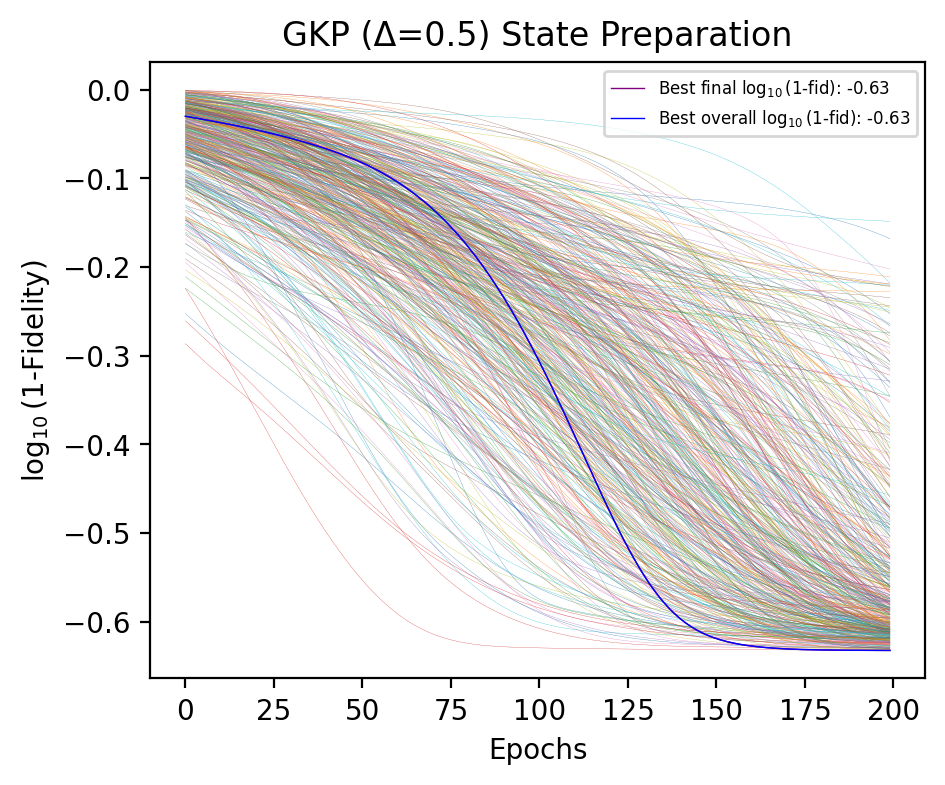

In [11]:
fig, ax = plt.subplots(1,1, dpi=200, figsize=(5,4))
ax.plot(jnp.log10(1-fids_history), linestyle='-', linewidth=0.1)
ax.plot(jnp.log10(1-fids_history[:,best_final_fid_batch_indx]), linestyle='-', linewidth=0.5, color='purple', label="Best final $\log_{10}$(1-fid): " + f"{log_infid_history[-1,best_final_fid_batch_indx]:.2}")
ax.plot(jnp.log10(1-fids_history[:,best_fid_batch_indx]), linestyle='-', linewidth=0.5, color='blue', label="Best overall $\log_{10}$(1-fid): " + f"{log_infid_history[best_fid_epoch_indx,best_fid_batch_indx]:.2}")
ax.set_xlabel("Epochs")
ax.set_ylabel(r"$\log_{10}$(1-Fidelity)")
ax.set_title(f"GKP (Δ={gkp_qubit.params['delta']}) State Preparation")
ax.legend(fontsize=6)

Best parameters: 
 [[-7.49833193e-01  1.29322783e-04 -4.99513540e-01 -4.99138069e-01
  -1.00023083e+00 -4.99758628e-01]
 [-3.00228401e-01 -4.99196358e-01 -1.97612145e-03  5.00489013e-01
   9.99067450e-01  4.98170515e-01]
 [ 2.24290454e+00 -1.78209328e+01  9.95697469e+00 -1.35399276e+01
  -1.59973367e+01 -4.81231081e-01]]


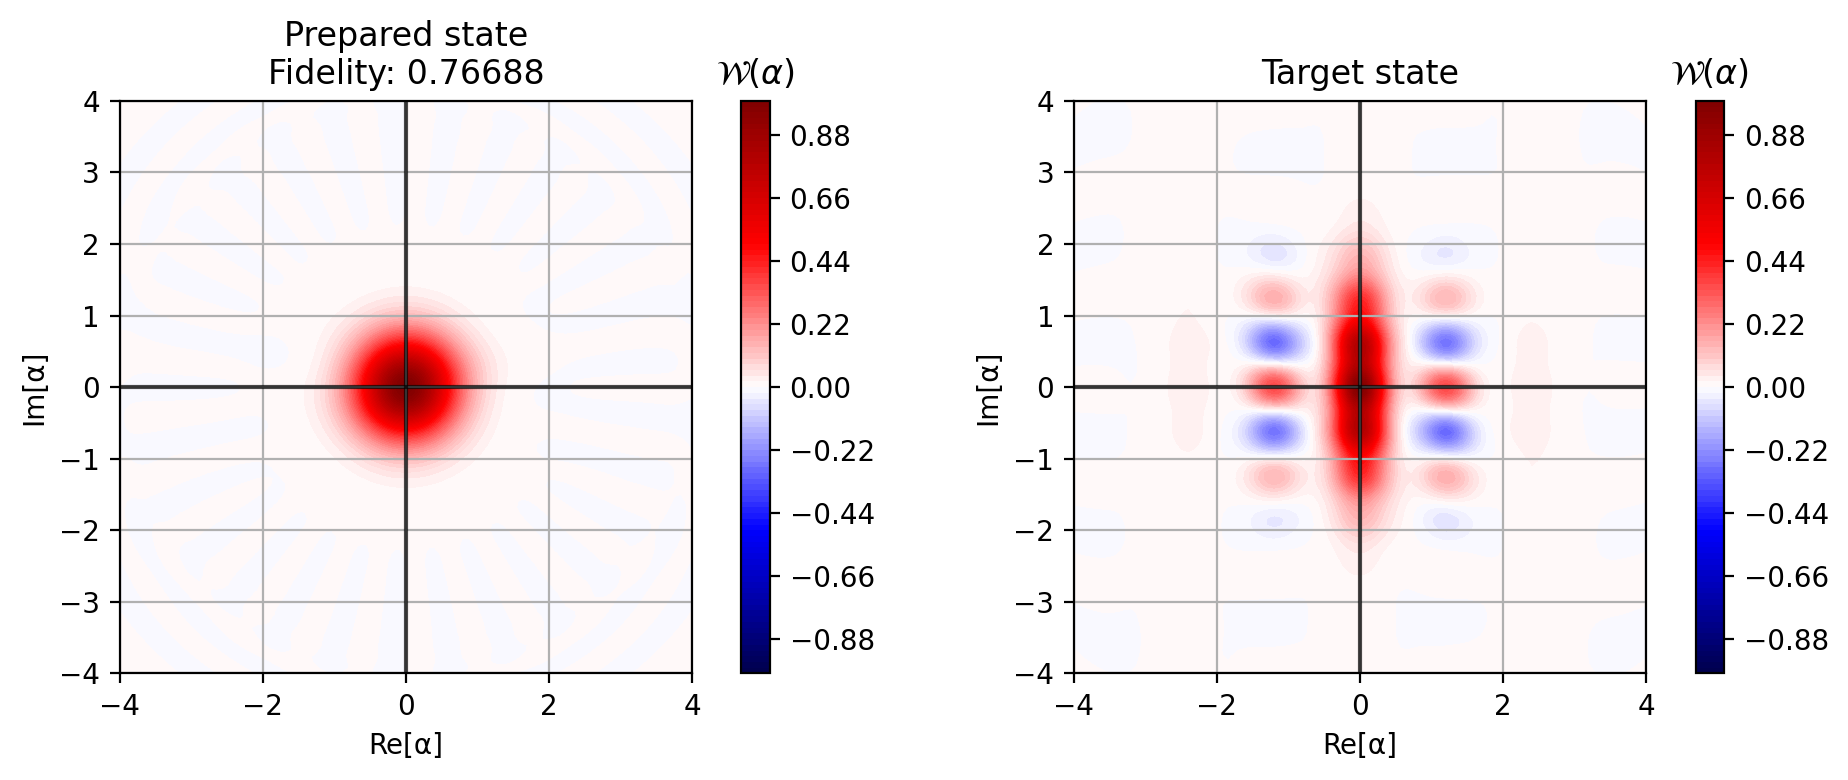

In [12]:
best_params = params_history[best_fid_epoch_indx, best_fid_batch_indx]
print("Best parameters: \n", best_params)


fig,axs = plt.subplots(1,2, dpi=200, figsize=(10,4))

state = run_circuit(best_params)
pts = jnp.linspace(-4,4, 101)
ax, im = jqt.plot_wigner(jqt.ptrace(state,1), pts, ax=axs[0])
ax.set_xlabel("Re[α]")
ax.set_ylabel("Im[α]")
ax.set_title("Prepared state\n" + f"Fidelity: {best_fid:.5f}")


pts = jnp.linspace(-4,4, 101)
ax, im = jqt.plot_wigner(target_state, pts, ax=axs[1])
ax.set_xlabel("Re[α]")
ax.set_ylabel("Im[α]")
ax.set_title("Target state")

fig.tight_layout()

Array(0.3, dtype=float64, weak_type=True)